In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dlrsd/DLRSD/legend.png
/kaggle/input/dlrsd/DLRSD/README.pdf
/kaggle/input/dlrsd/DLRSD/Labels/airplane/airplane45.png
/kaggle/input/dlrsd/DLRSD/Labels/airplane/airplane68.png
/kaggle/input/dlrsd/DLRSD/Labels/airplane/airplane15.png
/kaggle/input/dlrsd/DLRSD/Labels/airplane/airplane00.png
/kaggle/input/dlrsd/DLRSD/Labels/airplane/airplane37.png
/kaggle/input/dlrsd/DLRSD/Labels/airplane/airplane69.png
/kaggle/input/dlrsd/DLRSD/Labels/airplane/airplane49.png
/kaggle/input/dlrsd/DLRSD/Labels/airplane/airplane32.png
/kaggle/input/dlrsd/DLRSD/Labels/airplane/airplane93.png
/kaggle/input/dlrsd/DLRSD/Labels/airplane/airplane48.png
/kaggle/input/dlrsd/DLRSD/Labels/airplane/airplane62.png
/kaggle/input/dlrsd/DLRSD/Labels/airplane/airplane06.png
/kaggle/input/dlrsd/DLRSD/Labels/airplane/airplane24.png
/kaggle/input/dlrsd/DLRSD/Labels/airplane/airplane66.png
/kaggle/input/dlrsd/DLRSD/Labels/airplane/airplane60.png
/kaggle/input/dlrsd/DLRSD/Labels/airplane/airplane71.png
/kaggle/input/

In [24]:
import torch
from torch import nn
import torchvision

In [25]:
import os

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader,Subset
from torchvision import transforms
from pathlib import Path
import random
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import torch.optim as optim
from tqdm.notebook import tqdm
from tqdm import tqdm

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [27]:
class Unet(nn.Module):
    def __init__(self,n_class):
        super().__init__()
        #encoder
        self.e11= nn.Conv2d(3,64,kernel_size=3,padding=1)
        self.e12= nn.Conv2d(64,64,kernel_size=3,padding=1)
        self.pool1= nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.e21= nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.e22= nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.pool2= nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.e31= nn.Conv2d(128,256,kernel_size=3,padding=1)
        self.e32= nn.Conv2d(256,256,kernel_size=3,padding=1)
        self.pool3= nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.e41= nn.Conv2d(256,512,kernel_size=3,padding=1)
        self.e42= nn.Conv2d(512,512,kernel_size=3,padding=1)
        self.pool4= nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.e51= nn.Conv2d(512,1024,kernel_size=3,padding=1)
        self.e52= nn.Conv2d(1024,1024,kernel_size=3,padding=1)
        
        #decoder  
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256,128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)
        
        
    def forward(self,x):
        # Encoder
        xe11 = nn.ReLU()(self.e11(x))
        xe12 = nn.ReLU()(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = nn.ReLU()(self.e21(xp1))
        xe22 = nn.ReLU()(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = nn.ReLU()(self.e31(xp2))
        xe32 = nn.ReLU()(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = nn.ReLU()(self.e41(xp3))
        xe42 = nn.ReLU()(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = nn.ReLU()(self.e51(xp4))
        xe52 = nn.ReLU()(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = nn.ReLU()(self.d11(xu11))
        xd12 = nn.ReLU()(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = nn.ReLU()(self.d21(xu22))
        xd22 = nn.ReLU()(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = nn.ReLU()(self.d31(xu33))
        xd32 = nn.ReLU()(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = nn.ReLU()(self.d41(xu44))
        xd42 = nn.ReLU()(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out
    
n_class=17   
model = Unet(n_class)    
    
model.to(device)   

Unet(
  (e11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(512, 1024, kernel_size=(

In [28]:
def load_and_preprocess_mask(path):
    """
    Load and preprocess a mask image.
    
    :param path: Path to the mask image file.
    :return: A NumPy array representing the preprocessed image.
    """
    # Load the image using PIL
    img = Image.open(path).convert('RGB')  # Ensure image is in RGB mode
    
    # Define the preprocessing transformations
    transform = transforms.Compose([
        transforms.ToTensor()  # Converts image to tensor and scales pixel values to [0, 1]
    ])
    
    # Apply transformations
    img_tensor = transform(img)
    
    # Convert to NumPy array and scale values to [0, 255]
    img_np = img_tensor.numpy().transpose(1, 2, 0) * 255
    img_np = img_np.astype(np.uint8)
    
    return img_np

def load_and_preprocess_segment(path, img_size, colors):
    """
    Load and preprocess a segmentation mask image and create a one-hot encoded mask.
    
    :param path: Path to the mask image file.
    :param img_size: Tuple of image dimensions (height, width).
    :param colors: List of color values corresponding to classes.
    :return: A PyTorch tensor representing the one-hot encoded mask.
    """
    # Load and preprocess the mask image
    seg = load_and_preprocess_mask(path)
    
    # Initialize the mask array with zeros
    mask = np.zeros((256, 256, len(colors)), dtype=np.uint8)
    
    # Iterate over each color to create the one-hot encoded mask
    for i, color in enumerate(colors):
        # Create a binary mask for the current color
        cmap = np.all(np.equal(seg, color), axis=-1)
        mask[:, :, i] = cmap * 1

    
    # Convert the mask array to PyTorch tensor
    mask_tensor = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)  # Convert to CHW format
    
   
    
    return mask_tensor

# Example usage
IMG_SIZE1 = 256
IMG_SIZE2 = 256
colors = [
   [ 166 ,202, 240 ],
[ 128, 128, 0 ],
 [ 0 ,0, 128 ],
[ 255, 0 ,0 ],
[ 0 ,128 ,0 ],
 [ 128 ,0, 0 ],
 [ 255 ,233 ,233 ],
 [ 160, 160, 164 ],
 [ 0 ,128 ,128],
 [ 90 ,87, 255],
[ 255 ,255 ,0 ],
[ 255, 192, 0 ],
[ 0 ,0 ,255 ],
[ 255 ,0 ,192 ],
[ 128 ,0 ,128 ],
 [ 0 ,255, 0 ],
 [ 0 ,255 ,255 ]
    
]

# Load and preprocess the segmentation mask
path_to_mask = '/kaggle/input/dlrsd/DLRSD/Labels/agricultural/agricultural00.png'
mask_tensor = load_and_preprocess_segment(path_to_mask, (256, 256), colors)
print(mask_tensor.shape)  
print(mask_tensor)

torch.Size([17, 256, 256])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 

In [29]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir,img_size):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        
        
        self.img_size = img_size
        
        self.images_classes = sorted(os.listdir(image_dir))
        self.masks_classes = sorted(os.listdir(mask_dir))
        self.image_paths=[]
        self.masks_paths=[]
        
       
        for clas in sorted(self.images_classes):
            self.image= sorted(os.listdir(os.path.join(self.image_dir,clas)))
            for idx in range(100):
                self.image_paths.append(os.path.join(self.image_dir,clas,self.image[idx]))
                
        
        for clas in sorted(self.masks_classes):
            self.mask= sorted(os.listdir(os.path.join(self.mask_dir,clas)))
            for idx in range(100):
                self.masks_paths.append(os.path.join(self.mask_dir,clas,self.mask[idx]).replace('.tif','.png'))
                
        
    def __len__(self):
        
        return len(self.images_classes)*100
    
    def __getitem__(self, idx):
        
        
                
        
        img = Image.open(self.image_paths[idx]).convert('RGB')
        img = img.resize(self.img_size)
        img = np.array(img) / 255.0  # Normalize to [0, 1]
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # Convert to CHW format
         
        # Load and preprocess mask
        mask=load_and_preprocess_segment(self.masks_paths[idx],(256, 256), colors) 
        
        return img, mask

In [30]:
img_size=(256,256)

In [31]:
dataset = SegmentationDataset(image_dir="/kaggle/input/dlrsd/DLRSD/Images", mask_dir="/kaggle/input/dlrsd/DLRSD/Labels", img_size=img_size)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)


train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)

train_dataloader = DataLoader(train_subset, batch_size=8, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_subset, batch_size=8, shuffle=False, num_workers=4)

In [32]:
criterion = nn.CrossEntropyLoss()  # This will be used with integer labels, not one-hot
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [33]:
num_epochs =64

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for X, Y in tqdm(train_dataloader, total = len(train_dataloader), leave = False):
        optimizer.zero_grad()
        
        X,Y= X.to(device),Y.to(device)
        # Forward pass
        
        outputs = model(X)
        
        # Convert one-hot masks to class indices
        targets = Y.argmax(dim=1)
        
        # Compute loss
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

print("Training complete!")

Epoch [1/64], Loss: 1.9558


Epoch [2/64], Loss: 1.7345


Epoch [3/64], Loss: 1.6619


Epoch [4/64], Loss: 1.6044


Epoch [5/64], Loss: 1.5668


Epoch [6/64], Loss: 1.5192


Epoch [7/64], Loss: 1.5117


Epoch [8/64], Loss: 1.4423


Epoch [9/64], Loss: 1.3781


Epoch [10/64], Loss: 1.3190


Epoch [11/64], Loss: 1.2668


Epoch [12/64], Loss: 1.2357


Epoch [13/64], Loss: 1.1972


Epoch [14/64], Loss: 1.1679


Epoch [15/64], Loss: 1.1345


Epoch [16/64], Loss: 1.1103


Epoch [17/64], Loss: 1.0935


Epoch [18/64], Loss: 1.0848


Epoch [19/64], Loss: 1.0429


Epoch [20/64], Loss: 1.0133


Epoch [21/64], Loss: 0.9947


Epoch [22/64], Loss: 0.9735


Epoch [23/64], Loss: 0.9442


Epoch [24/64], Loss: 0.9216


Epoch [25/64], Loss: 0.9027


Epoch [26/64], Loss: 0.8911


Epoch [27/64], Loss: 0.8761


Epoch [28/64], Loss: 0.8546


Epoch [29/64], Loss: 0.8330


Epoch [30/64], Loss: 0.8259


Epoch [31/64], Loss: 0.7977


Epoch [32/64], Loss: 0.7800


Epoch [33/64], Loss: 0.7749


Epoch [34/64], Loss: 0.7726


Epoch [35/64], Loss: 0.7489


Epoch [36/64], Loss: 0.7249


Epoch [37/64], Loss: 0.7008


Epoch [38/64], Loss: 0.7046


Epoch [39/64], Loss: 0.6928


Epoch [40/64], Loss: 0.6731


Epoch [41/64], Loss: 0.7149


Epoch [42/64], Loss: 0.6813


Epoch [43/64], Loss: 0.6482


Epoch [44/64], Loss: 0.6231


Epoch [45/64], Loss: 0.6010


Epoch [46/64], Loss: 0.5994


Epoch [47/64], Loss: 0.6087


Epoch [48/64], Loss: 0.5798


Epoch [49/64], Loss: 0.5448


Epoch [50/64], Loss: 0.5345


Epoch [51/64], Loss: 0.5069


Epoch [52/64], Loss: 0.5460


Epoch [53/64], Loss: 0.4951


Epoch [54/64], Loss: 0.4725


Epoch [55/64], Loss: 0.4321


Epoch [56/64], Loss: 0.4167


Epoch [57/64], Loss: 0.4062


Epoch [58/64], Loss: 0.4498


Epoch [59/64], Loss: 0.4062


Epoch [60/64], Loss: 0.3660


Epoch [61/64], Loss: 0.3325


Epoch [62/64], Loss: 0.3300


Epoch [63/64], Loss: 0.3114


Epoch [64/64], Loss: 0.2972
Training complete!


In [34]:
import torch

def calculate_iou(pred, target, num_classes):
   
    # Convert predictions to class indices
    pred = torch.argmax(pred, dim=1)
    
    # Initialize the IoU scores
    iou_scores = []
    
    for cls in range(num_classes):
        # Get binary masks for the current class
        pred_mask = (pred == cls)
        target_mask = (target == cls)
        
        # Calculate intersection and union
        intersection = torch.sum(pred_mask & target_mask).item()
        union = torch.sum(pred_mask | target_mask).item()
        
        if union == 0:
            iou = float('nan')  # If there is no union, IoU is not defined
        else:
            iou = intersection / union
        
        iou_scores.append(iou)
    
    # Calculate the mean IoU, ignoring NaN values
    mean_iou = torch.tensor(iou_scores).nanmean().item()
    
    return iou_scores, mean_iou


model.eval()
num_classes = 17  

iou_scores_list = []

with torch.no_grad():
    for X, Y in test_dataloader:
        X, Y = X.to(device), Y.to(device)
        Y = Y.argmax(dim=1)
        y_pred = model(X)
        
        # Get IoU scores for the batch
        iou_scores, mean_iou = calculate_iou(y_pred, Y, num_classes)
        iou_scores_list.append(mean_iou)

# Calculate the average IoU over the dataset
average_iou = sum(iou_scores_list) / len(iou_scores_list)
print(f"Mean IoU over the test dataset: {average_iou:.4f}")

Mean IoU over the test dataset: 0.3590


# **Final Answer on test dataset ^**

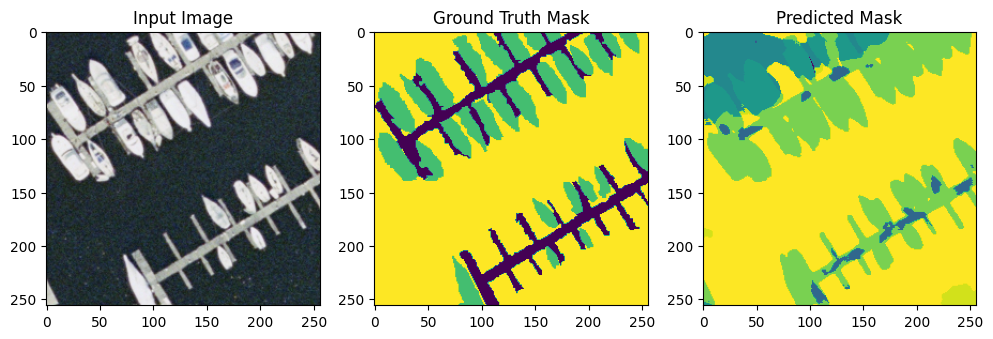

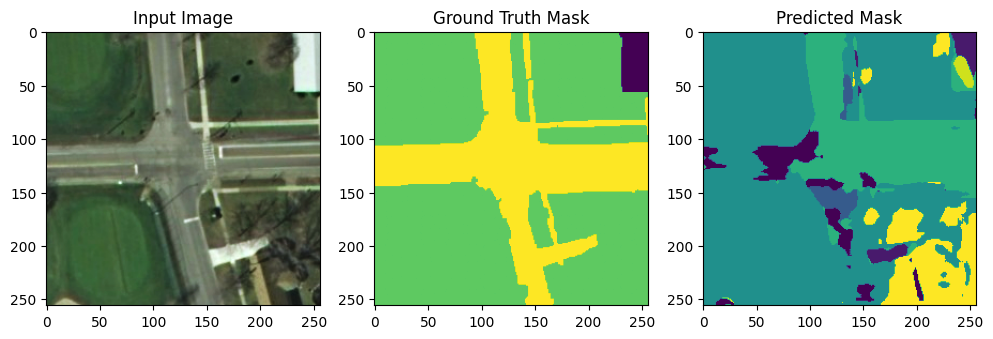

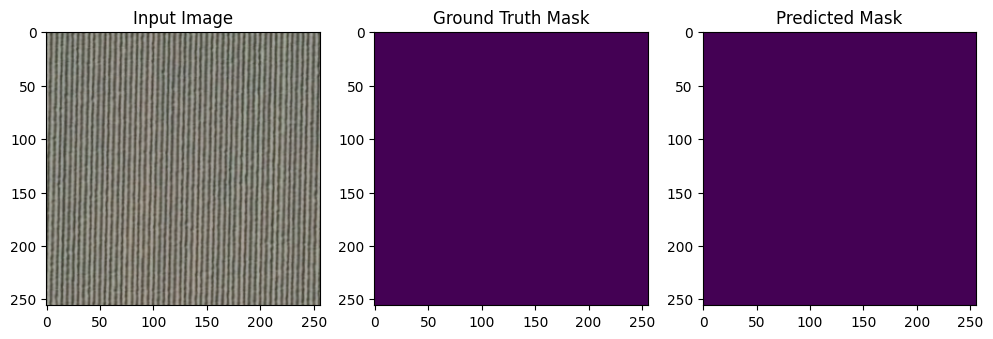

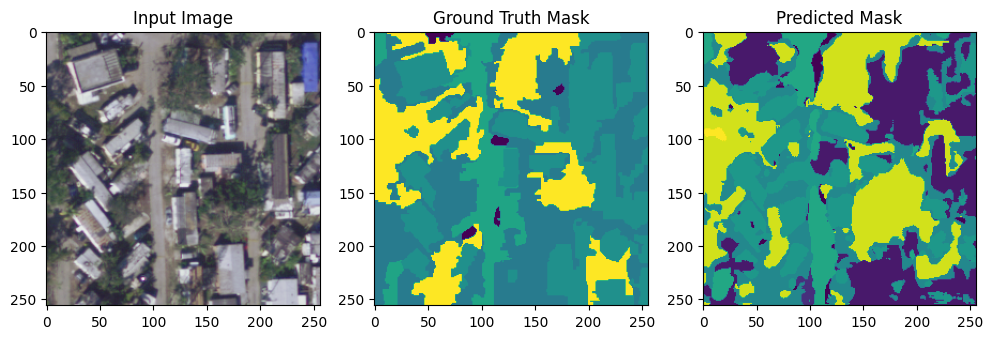

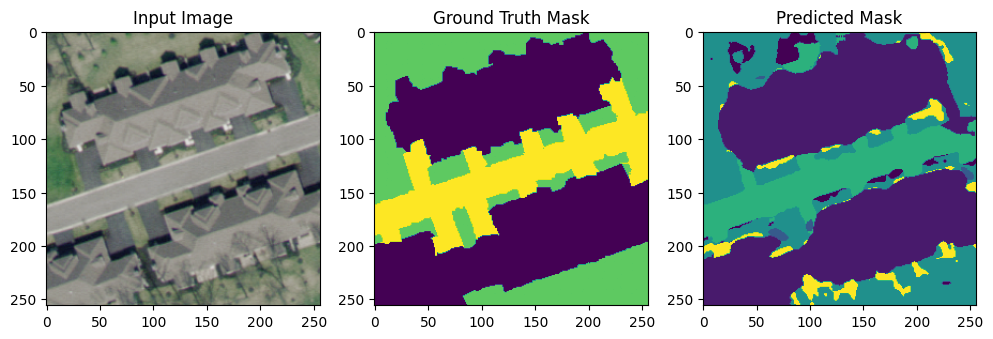

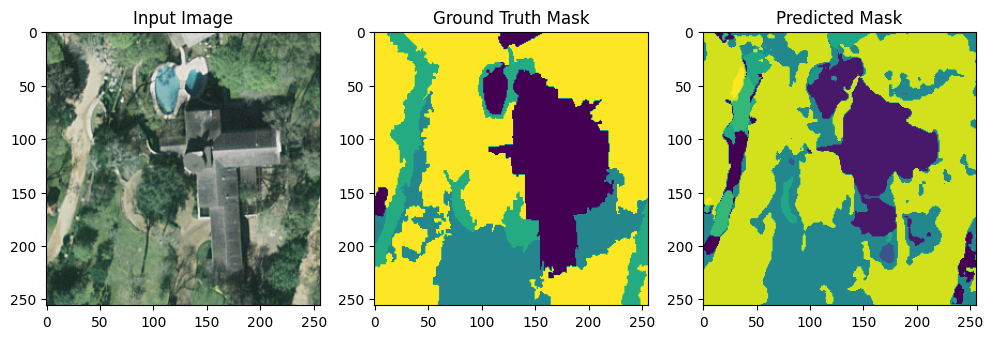

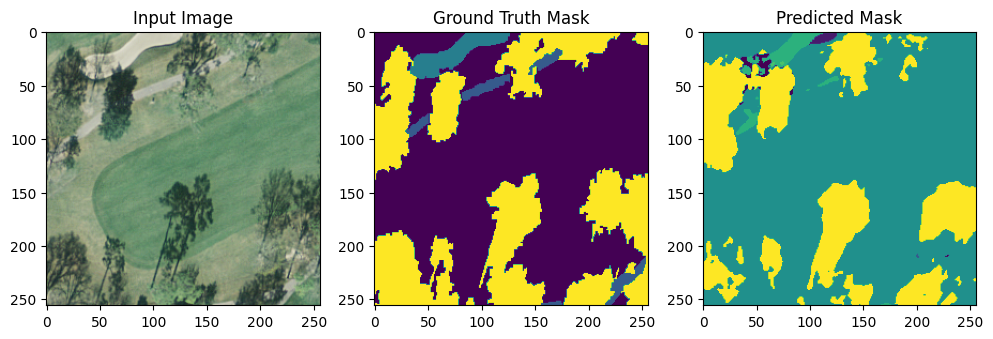

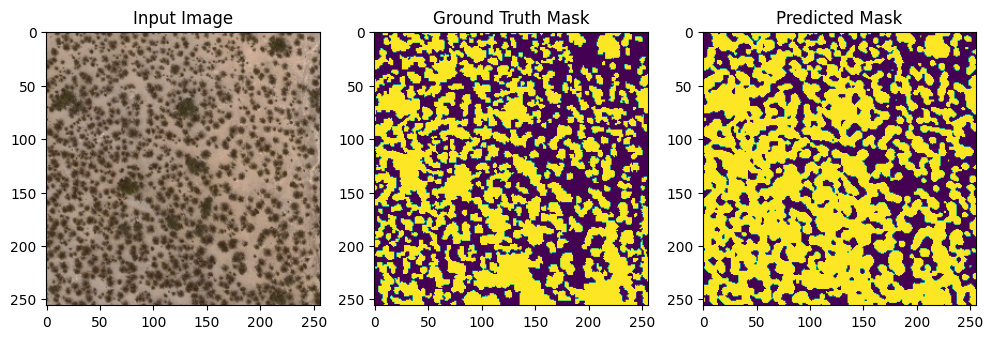

In [35]:
def visualize_segmentation(model, dataloader, device):
    model.eval()
    
    with torch.no_grad():
        for batch in dataloader:
            images, masks = batch
            images, masks = images.to(device), masks.to(device)
            
            preds = model(images)
            preds = torch.argmax(preds, dim=1)  # Get the class with the highest probability

            images_np = images.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to HWC format
            masks_np = torch.argmax(masks, dim=1).cpu().numpy()     # Convert one-hot to class indices
            preds_np = preds.cpu().numpy()

            batch_size = images_np.shape[0]

            for i in range(batch_size):
                plt.figure(figsize=(12, 6))
                
                # Input image
                plt.subplot(1, 3, 1)
                plt.imshow(images_np[i])
                plt.title("Input Image")
                
                # Ground truth mask (class index for each pixel)
                plt.subplot(1, 3, 2)
                plt.imshow(masks_np[i])
                plt.title("Ground Truth Mask")
                
                # Predicted mask (class index for each pixel)
                plt.subplot(1, 3, 3)
                plt.imshow(preds_np[i])
                plt.title("Predicted Mask")
                
                plt.show()
            break  # Display only one batch for simplicity

# Now call the function to visualize
visualize_segmentation(model, test_dataloader, device)